# General Backtester for ATM Panoptions 
On:
- Any Uni V3 Pool
- Any Time Period
- Any Range Factor
- Any # of put & call legs
- Includes Subsample Testing

### Import Python Packages

In [1]:
import pandas as pd
import pandas_gbq
import pydata_google_auth
import numpy as np
import matplotlib.pyplot as plt
import math
import calendar

from tqdm import tqdm
from datetime import timedelta
from functools import reduce
pd.options.mode.chained_assignment = None

### Parse Data

In [2]:
class LP_Rebalance:
    def __init__(
        self,
        token_0: str,
        token_1: str,
        fee: int, # in bps
        local_dir: str,
        start_t: str,
        end_t: str,
        range_perc: float, # i.e. +/- 30%
        col_ratio: float=100, # i.e. 100%
        com_ratio: float=0, # i.e. 0bps
        PLP_annual_yield: float=0, # i.e. 0%
        spread_mult: float=1,
        pool_data: pd.DataFrame=None,
        inverse_price: bool=True,
        legs: dict={'short_put': 1},
    ) -> None:
        """
        Initialize LP Rebalancing class
        
        :token_0 Token 0
        :token_1 Token 1
        :fee fee rate in bps
        :local_dir local directory to save plots
        :start_t start time (inclusive) (i.e. '2021-05-06 00:06:12' or '2021-05-06')
        :end_t end time (exclusive)
        :range_perc range percent (for +/- 30%, input 30)
        :col_ratio collateral ratio (%) - assumes position is never underwater or liquidated
        :com_ratio commission ratio (bps)
        :PLP_annual_yield annual yield from providing Panoptic liquidity (%)
        :spread_mult spread multiplier for buying popular options
        :pool_data enter dataframe of pool data from another strategy to save load time. Default=None
        :inverse_price invert the price (if true: gets price of token_1 in terms of token_0)
        :legs type of option ['SHORT_PUT', 'LONG_PUT', 'SHORT_CALL', 'LONG_CALL'] and quantity
        """
        self.token_0 = token_0
        self.token_1 = token_1
        self.fee_rate = fee / 10_000
        self.pool_address = LP_Rebalance.get_pool_address(self.token_0, self.token_1, fee)
        self.dec_0 = LP_Rebalance.get_token_dec(self.token_0)
        self.dec_1 = LP_Rebalance.get_token_dec(self.token_1)
        self.tick_spacing = LP_Rebalance.get_tick_spacing(fee)
        ''' Our_capital is 1 b/c it allows results to be interpreted as percentages
        Strategy does accounting in numeraire token
        I.e. start with 1 token of numeraire, split 50/50 to LP.
        At end of rebalancing period (e.g. 1 day), we sell everything back into the numeraire token
        And calculate the % change (return) on the numeraire token '''
        self.our_capital = 1 # in token y
        self.raw_dir = local_dir
        self.start_t = start_t
        self.end_t = end_t
        self.range_perc = (range_perc / 100) + 1
        self.tick_width = LP_Rebalance.convert_r_to_tick_width(self.range_perc)
        self.col_ratio = col_ratio / 100
        self.com_ratio = com_ratio / 10_000
        self.collateral = self.our_capital * self.col_ratio
        self.PLP_annual_yield = PLP_annual_yield / 100
        self.spread_mult = spread_mult
        ''' If inverse_price, our numeraire is token_0
        Else, our numeraire is token_1
        Ex: For USDC/ETH pool:
        token 0 = USDC
        token 1 = ETH
        Inverse_price = True -> we calculate returns in terms of USDC
        Inverse_price = False -> we calculate returns in terms of ETH
        This will affect results! '''
        self.inverse_price = inverse_price

        valid_options = ['SHORT_PUT', 'LONG_PUT', 'SHORT_CALL', 'LONG_CALL']
        for leg in legs:
            if leg not in valid_options:
                raise BaseException(f"Invalid option type. Valid types: {valid_options}")
        self.legs = legs

        self.BASE = 1.0001

        if pool_data is None:
            self.load_pool_data()
        else:
            self.data = pool_data
        

    def load_pool_data(self):
        """Loads Univ3 pool swap data"""
        # Replace this function with your own GBQ data fetcher
        # See: https://github.com/panoptic-labs/research/blob/JP/_research-bites/DataTutorial/tutorial.ipynb
        print("Loading Data...")

        SCOPES = [
            'https://www.googleapis.com/auth/cloud-platform',
            'https://www.googleapis.com/auth/drive',
        ]

        credentials = pydata_google_auth.get_user_credentials(
            SCOPES,
            auth_local_webserver=True,
        )

        query = f"""
        SELECT DISTINCT *
        FROM `arcane-world-371019.First_sync.1`
        WHERE address = '{self.pool_address}'
            AND block_timestamp >= '{self.start_t}'
            AND block_timestamp < '{self.end_t}'
        ORDER BY block_number, transaction_index
        """
        self.data = pandas_gbq.read_gbq(query, project_id = "arcane-world-371019", credentials=credentials)
        self.transform_pool_data()

    def transform_pool_data(self):
        """Transform amounts to human-readable format"""
        self.data['amount0'] = self.data['amount0'].apply(LP_Rebalance.get_twos_comp)
        self.data['amount1'] = self.data['amount1'].apply(LP_Rebalance.get_twos_comp)

        self.data['amount0'] = self.data['amount0'] / (10 ** self.dec_0)
        self.data['amount1'] = self.data['amount1'] / (10 ** self.dec_1)

        self.data['price'] = self.data['tick'].apply(self.convert_tick)

        # Note our GBQ query ordered by blocknumber, transaciton_index
        self.data.set_index('block_timestamp', inplace=True) # Assume block timestamps are accurate "enough" for our use-case
        self.data.index = pd.to_datetime(self.data.index)

        # Unpack sqrt price
        self.data['sqrtPrice'] = self.data['sqrtPrice'].apply(LP_Rebalance.unpack_sqrtprice)

        # Calculate sqrt price change
        self.data = LP_Rebalance.calc_sqrtprice_change(self.data)

        self.data['date'] = self.data.index.date
        # Lag prices (Have to do for illiquid pools w/few txs per day)
        self.data['price_lag'] = self.data['price'].shift()
        self.data['tick_lag'] = self.data['tick'].shift()
        self.data['sqrtPrice_lag'] = self.data['sqrtPrice'].shift()
        self.data = self.data.iloc[1:]

    def run_strat(self):
        print("Running Strategy")
        self.create_strat()

        # Calculate liquidity per tick
        tqdm().pandas(desc='Step 1')
        self.daily['liq_per_tick'] = self.daily.progress_apply(self.calc_liq_per_tick, axis=1)
        self.weekly['liq_per_tick'] = self.weekly.progress_apply(self.calc_liq_per_tick, axis=1)
        self.monthly['liq_per_tick'] = self.monthly.progress_apply(self.calc_liq_per_tick, axis=1)

        # Calculate fees
        tqdm().pandas(desc='Step 2')
        self.daily[['our_fee', 'fee_asset']] = self.daily.progress_apply(self.calc_fees, axis=1)
        self.weekly[['our_fee', 'fee_asset']] = self.weekly.progress_apply(self.calc_fees, axis=1)
        self.monthly[['our_fee', 'fee_asset']] = self.monthly.progress_apply(self.calc_fees, axis=1)

        quantity_total = sum(self.legs.values())
        
        self.daily_fees_legs = {}
        for leg, quantity in self.legs.items():
            self.daily_fees_legs[leg] = self.daily.groupby('date').apply(self.get_fee_summary, leg) * quantity
        self.daily_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.daily_fees_legs.values())
        self.daily_fees.rename(columns={0: 'fees_total'}, inplace=True)
        self.daily_fees['fees_perc'] = self.daily_fees['fees_total'] / (self.collateral * quantity_total)

        self.weekly_fees_legs = {}
        for leg, quantity in self.legs.items():
            self.weekly_fees_legs[leg] = self.weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')]).apply(self.get_fee_summary, leg) * quantity
        self.weekly_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.weekly_fees_legs.values())
        self.weekly_fees.rename(columns={0: 'fees_total'}, inplace=True)
        self.weekly_fees['fees_perc'] = self.weekly_fees['fees_total'] / (self.collateral * quantity_total)
        self.weekly_fees.index = self.weekly_fees.index.date
        self.weekly_fees.index.name = 'date'

        self.monthly_fees_legs = {}
        for leg, quantity in self.legs.items():
            self.monthly_fees_legs[leg] = self.monthly.groupby(['year', 'month']).apply(self.get_fee_summary, leg) * quantity
        self.monthly_fees = reduce(lambda x, y: x.add(y, fill_value=0), self.monthly_fees_legs.values())
        self.monthly_fees.rename(columns={0: 'fees_total'}, inplace=True)
        self.monthly_fees['fees_perc'] = self.monthly_fees['fees_total'] / (self.collateral * quantity_total)
        y = self.monthly_fees.index.get_level_values('year')
        m = self.monthly_fees.index.get_level_values('month')
        self.monthly_fees.index = pd.to_datetime(y * 10000 + m * 100 + 1, format="%Y%m%d")
        self.monthly_fees.index = [dti.replace(day = calendar.monthrange(dti.year, dti.month)[1]).date() for dti in self.monthly_fees.index]
        self.monthly_fees.index.name = 'date'
        self.monthly_fees.loc[self.daily_fees.index[0]] = [None, 0]
        self.monthly_fees.sort_index(inplace=True)

        # Calculate PnL
        tqdm().pandas(desc='Step 3')
        self.daily_pos_legs = {}
        for leg, quantity in self.legs.items():
            self.daily_pos_legs[leg] = self.daily.groupby('date').progress_apply(self.calc_position, option_type=leg) * quantity
        self.daily_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.daily_pos_legs.values())
        # Assumes same collateralization for each leg (TODO: allow customizable collateral)
        self.daily_pos['pnl_perc'] = self.daily_pos['pnl'] / (self.collateral * quantity_total)

        self.weekly_pos_legs = {}
        for leg, quantity in self.legs.items():
            self.weekly_pos_legs[leg] = self.weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')]).progress_apply(self.calc_position, option_type=leg) * quantity
        self.weekly_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.weekly_pos_legs.values())
        self.weekly_pos['pnl_perc'] = self.weekly_pos['pnl'] / (self.collateral * quantity_total)
        self.weekly_pos.index = self.weekly_pos.index.date
        self.weekly_pos.index.name = 'date'

        self.monthly_pos_legs = {}
        for leg, quantity in self.legs.items():
            self.monthly_pos_legs[leg] = self.monthly.groupby(['year', 'month']).progress_apply(self.calc_position, option_type=leg) * quantity
        self.monthly_pos = reduce(lambda x, y: x.add(y, fill_value=0), self.monthly_pos_legs.values())
        self.monthly_pos['pnl_perc'] = self.monthly_pos['pnl'] / (self.collateral * quantity_total)

        y = self.monthly_pos.index.get_level_values('year')
        m = self.monthly_pos.index.get_level_values('month')
        self.monthly_pos.index = pd.to_datetime(y * 10000 + m * 100 + 1, format="%Y%m%d")
        self.monthly_pos.index = [dti.replace(day = calendar.monthrange(dti.year, dti.month)[1]).date() for dti in self.monthly_pos.index]
        self.monthly_pos.index.name = 'date'
        self.monthly_pos.loc[self.daily_pos.index[0]] = [None, None, None, None, None, None, 0]
        self.monthly_pos.sort_index(inplace=True)

        # Calculate Commissions paid
        self.update_commissions(self.com_ratio * 10_000)

        # Calculate PLP yield earned
        self.update_PLP_yield(self.PLP_annual_yield * 100)

    def update_commissions(self, com_ratio: float) -> None:
        """
        Update commission ratio

        :com_ratio commission ratio (bps)
        """
        self.com_ratio = com_ratio / 10_000
        coms_total = -1 * self.com_ratio * self.our_capital
        coms_perc = coms_total / self.collateral
        self.daily_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.daily_pos.index)
        self.weekly_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.weekly_pos.index)
        self.monthly_com = pd.DataFrame({'coms_total': coms_total, 'coms_perc': coms_perc}, index=self.monthly_pos.index)

    def update_PLP_yield(self, PLP_annual_yield: float) -> None:
        """
        Update Panoptic LP annual yield

        :PLP_annual_yield PLP annual yield (%)
        """
        self.PLP_annual_yield = PLP_annual_yield / 100
        daily_yield = self.PLP_annual_yield / 365
        weekly_yield = self.PLP_annual_yield / 52
        monthly_yield = self.PLP_annual_yield / 12
        self.daily_PLP_yield = pd.DataFrame({'PLP_yield_total': daily_yield * self.collateral, 'PLP_yield_perc': daily_yield}, index=self.daily_pos.index)
        self.weekly_PLP_yield = pd.DataFrame({'PLP_yield_total': weekly_yield * self.collateral, 'PLP_yield_perc': weekly_yield}, index=self.weekly_pos.index)
        self.monthly_PLP_yield = pd.DataFrame({'PLP_yield_total': monthly_yield * self.collateral, 'PLP_yield_perc': monthly_yield}, index=self.monthly_pos.index)

    def update_spread_mult(self, spread_mult: float) -> None:
        """
        Update spread multiplier

        :spread_mult spread multiplier (e.g. 1.25X)
        """ 
        for fees in [self.daily_fees, self.weekly_fees, self.monthly_fees]:
            fees['fees_total'] *= spread_mult / self.spread_mult
            fees['fees_perc'] = fees['fees_total'] / self.collateral
        self.spread_mult = spread_mult

    def create_strat(self):
        """
        Define Rebalancing Strategies
        Define 3 strategies: LP +/- X% of start price and rebalance (1) daily, (2) weekly, and (3) monthly
        -Assumes no rebalancing costs in terms of gas fees or slippage/swap fees
        -Assumes no reinvestment/LPing of collected fees
        """
        daily = self.data.copy()
        weekly = self.data.copy()
        monthly = self.data.copy()

        daily['price_start'] = daily.groupby('date')['price_lag'].transform(lambda x: x[0])
        daily['tick_start'] = daily.groupby('date')['tick_lag'].transform(lambda x: x[0])
        daily['sqrtPrice_start'] = daily.groupby('date')['sqrtPrice_lag'].transform(lambda x: x[0])
        daily['price_a'] = daily['price_start'] / self.range_perc
        daily['price_b'] = daily['price_start'] * self.range_perc
        self.daily = daily

        # Rebalance every Monday (UTC)
        weekly['price_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['price_lag'].transform(lambda x: x[0])
        weekly['tick_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['tick_lag'].transform(lambda x: x[0])
        weekly['sqrtPrice_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['sqrtPrice_lag'].transform(lambda x: x[0])
        weekly['price_a'] = weekly['price_start'] / self.range_perc
        weekly['price_b'] = weekly['price_start'] * self.range_perc
        self.weekly = weekly

        # Rebalance on the 1st of the month
        monthly['month'] = monthly.index.month
        monthly['year'] = monthly.index.year
        monthly['price_start'] = monthly.groupby(['year', 'month'])['price_lag'].transform(lambda x: x[0])
        monthly['tick_start'] = monthly.groupby(['year', 'month'])['tick_lag'].transform(lambda x: x[0])
        monthly['sqrtPrice_start'] = monthly.groupby(['year', 'month'])['sqrtPrice_lag'].transform(lambda x: x[0])
        monthly['price_a'] = monthly['price_start'] / self.range_perc
        monthly['price_b'] = monthly['price_start'] * self.range_perc
        self.monthly = monthly

    def calc_fees(self, s: pd.Series) -> pd.Series:
        """Calculate fee collected by us per swap
        (Uses sqrtPrice and liq_per_tick)"""
        # We ignore decimals for sqrtPrice - they end up cancelling out in calc_liq_per_tick(), calc_fees(), and get_fee_summary()
        # Our fees
        low_bound = np.sqrt(self.BASE ** (s['tick_start'] - self.tick_width))
        up_bound = np.sqrt(self.BASE ** (s['tick_start'] + self.tick_width))
        prev_adj = np.clip(s['prev_sqrtPrice'], low_bound, up_bound)
        curr_adj = np.clip(s['sqrtPrice'], low_bound, up_bound)

        if s['change_sqrtPrice'] >= 0: # price of token 0 in token 1 went up -> fee collected in token 1
            fee_asset = self.token_1
            our_fee = s['liq_per_tick'] * (curr_adj - prev_adj) * self.fee_rate
        
        else: # price of token 0 in token 1 went down -> fee collected in token 0
            fee_asset = self.token_0
            our_fee = s['liq_per_tick'] * ((1 / curr_adj) - (1 / prev_adj)) * self.fee_rate

        return pd.Series([our_fee, fee_asset])

    def get_fee_summary(self, df: pd.DataFrame, option_type: str) -> pd.Series:
        """Get daily summary statistics of our collected fees"""
        # We ignore decimals for sqrtPrice - they end up cancelling out in calc_liq_per_tick(), calc_fees(), and get_fee_summary()
        price_close = df['price'][-1]
        sqrtPrice_close = df['sqrtPrice'][-1]

        # Our performance
        fees_0 = df.loc[df['fee_asset'] == self.token_0, 'our_fee'].sum()
        fees_1 = df.loc[df['fee_asset'] == self.token_1, 'our_fee'].sum()

        fees_total = fees_1 + fees_0 * (sqrtPrice_close ** 2) # in terms of token 1 (with dec_1)

        if self.inverse_price:
            fees_total *= price_close # in terms of token 0

        fees_total *= self.spread_mult # Fees owed to seller are multiplied by "spread" for popular strike prices
        
        short_options = ['SHORT_PUT', 'SHORT_CALL']
        long_options = ['LONG_PUT', 'LONG_CALL']
        if option_type in long_options:
            fees_total *= -1 # Fees are owed

        # fees_perc = fees_total / self.collateral

        return pd.Series([
                        fees_total,
                        ])

    def calc_position(self, df: pd.DataFrame, option_type: str) -> pd.Series:
        """
        Calculates strategy position in token y, the numeraire
        (if inverse_price then this is token_0, else token_1)
        and daily returns (excluding fees).
        Expects df to be LP data of swaps.

        p_a: lower price range
        p_b: upper price range
        p_0: mid-price (initial price)
        x_0: initial amount of token x
        y_0: initial amount of token y

        p_1: price at beginning of day (same as p_0
            for daily rebalancing but different for
            weekly and monthly rebalancing)
        x_1: amount of token x at BOD
        y_1: amount of token y at BOD

        p: current (close) price at EOD
        x: current amount of token x
        y: current amount of token y
        IL: impermanent loss (loss compared to HODLing)

        """
        # Initial LP price range and positions
        p_a = df['price_a'][-1]
        p_b = df['price_b'][-1]
        p_0 = df['price_start'][-1]
        x_0 = (self.our_capital / p_0) / 2 # Start with 1 unit of token y. Split between x and y
        y_0 = self.our_capital / 2 # In the case of USDC this is just $0.50
        pos_0_y = self.our_capital
        pos_0_x = pos_0_y / p_0

        # https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf
        L_x = x_0 * ((np.sqrt(p_0) * np.sqrt(p_b)) / (np.sqrt(p_b) - np.sqrt(p_0)))
        L_y = y_0 / (np.sqrt(p_0) - np.sqrt(p_a))
        L = min(L_x, L_y)

        # End of day position
        p = df['price'][-1] # close (current) price
        p_adj = np.clip(p, p_a, p_b) # ensures price used for calculating token amts d/n exceed price range
        x = L * (np.sqrt(p_b) - np.sqrt(p_adj)) / (np.sqrt(p_adj) * np.sqrt(p_b))
        y = L * (np.sqrt(p_adj) - np.sqrt(p_a))
        pos_y = x * p + y # in token y
        pos_x = pos_y / p

        if option_type == 'SHORT_PUT':
            # Same as LPing
            pnl_y = pos_y - pos_0_y # in token y
        elif option_type == 'LONG_PUT':
            # Option buyer owns pos_0_y (our_capital) since LP position immediately swapped to token y when borrowed
            # Option buyer owes pos_y to option seller
            pnl_y = pos_0_y - pos_y # in token y
        elif option_type == 'SHORT_CALL':
            # LPing but with borrowed token x
            # Short call = short put + short token x
            pnl_x = pos_x - pos_0_x
            pnl_y = pnl_x * p
        elif option_type == 'LONG_CALL':
            # Option buyer owns pos_0_x since LP position immediately swapped to token x when borrowed
            # Option buyer owes pos_x to option seller
            pnl_x = pos_0_x - pos_x
            pnl_y = pnl_x * p
        # pnl_perc = pnl_y / self.collateral

        return pd.Series({
            'x_0': x_0,
            'y_0': y_0,
            'x': x,
            'y': y,
            'pos': pos_y,
            'pnl': pnl_y,
        })

    def convert_price(self, p: float) -> float:
        """Gets (inverse) price (convenient for pairs like USDC/ETH)
        Inverse price: price of token1 in terms of token0
        Regular price: price of token0 in terms of token1"""
        if self.inverse_price:
            return 10 ** (self.dec_1 - self.dec_0) / p
        else:
            return p / (10 ** (self.dec_1 - self.dec_0))

    def convert_tick(self, tick: int) -> float:
        """Converts tick to price"""
        return self.convert_price(self.BASE ** tick)

    def convert_price_to_tick(self, p: float) -> float:
        """Converts price to tick"""    
        return math.log(self.convert_price(p), self.BASE)

    def calc_liq_per_tick(self, s: pd.Series) -> float:
        """
        Calculates our liquidity per tick
        (see https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf)
        """
        ''' Do not invert prices for calculating liquidity per tick
        (This is an input to self.calc_fees() which uses sqrtPrice and assumes no inverted price)
        Note that sqrtPrice should be multiplied by 10 ^ [(dec0 - dec1) / 2]
        (or alternative multiply sqrtPrice ^2 by 10 ^ (dec0 - dec1))
        to achieve correct decimal places
        But we ignore decimals here, as they end up cancelling out in anyway in calc_liq_per_tick(), calc_fees(), and get_fee_summary() '''
        price = s['sqrtPrice_start'] ** 2
        p_a = price / self.range_perc

        p_0 = s['price_start']
        if self.inverse_price:
            y_0 = (self.our_capital / p_0) / 2
        else:
            y_0 = self.our_capital / 2 # In the case of USDC this is just $0.50

        # # Initial liquidity per tick
        L = y_0 / (np.sqrt(price) - np.sqrt(p_a))
        return L

    @staticmethod
    def convert_r_to_tick_width(r: float) -> float:
        """Converts range factor to tick width
        
        :r range factor
        """
        return math.log(r, 1.0001)

    @staticmethod
    def calc_sqrtprice_change(df: pd.DataFrame) -> pd.DataFrame:
        """Stores previous sqrt price and calculates delta"""
        df['prev_sqrtPrice'] = df['sqrtPrice'].shift()
        df['change_sqrtPrice'] = df['sqrtPrice'] - df['prev_sqrtPrice']
        return df

    @staticmethod
    def unpack_sqrtprice(sqrt_p: str) -> float:
        """Unpacks sqrt price from raw UNI V3 pool data"""
        return int(sqrt_p, 16) / (2 ** 96)

    @staticmethod
    def get_twos_comp(hex_str: str, bits: int=256) -> float:
        """Calculate two's complement"""
        num = int(hex_str, 16)
        if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
            num = num - (1 << bits)        # Get two's complement
        return num

    @staticmethod
    def get_pool_address(token_0: str, token_1: str, fee: int) -> str:
        """Gets Univ3 Pool Address"""
        # Source: https://info.uniswap.org/#/pools
        # Feel free to add additional pools
        # (make sure token0 and token1 are specified in the same order as on Uniswap!)
        # Ex: '[token0]/[token1] [fee]bps': '[pool_address]',
        pools = {
            '1INCH/ETH 100bps': '0xe931b03260b2854e77e8da8378a1bc017b13cb97',
            'AAVE/ETH 30bps': '0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb',
            'APE/ETH 30bps': '0xac4b3dacb91461209ae9d41ec517c2b9cb1b7daf',
            'BIT/ETH 30bps': '0x5c128d25a21f681e678cb050e551a895c9309945',
            'BUSD/USDC 5bps': '0x00cef0386ed94d738c8f8a74e8bfd0376926d24c',
            'cbETH/ETH 5bps': '0x840deeef2f115cf50da625f7368c24af6fe74410',
            'DAI/ETH 5bps': '0x60594a405d53811d3bc4766596efd80fd545a270',
            'DAI/ETH 30bps': '0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8',
            'DAI/USDC 1bps': '0x5777d92f208679db4b9778590fa3cab3ac9e2168',
            'DAI/USDC 5bps': '0x6c6bc977e13df9b0de53b251522280bb72383700',
            'DAI/FRAX 5bps': '0x97e7d56a0408570ba1a7852de36350f7713906ec',
            'ETH/BTT 30bps': '0x64a078926ad9f9e88016c199017aea196e3899e1',
            'ETH/ENS 30bps': '0x92560c178ce069cc014138ed3c2f5221ba71f58a',
            'ETH/LOOKS 30bps': '0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011',
            'ETH/sETH2 30bps': '0x7379e81228514a1d2a6cf7559203998e20598346',
            'ETH/USDT 5bps': '0x11b815efb8f581194ae79006d24e0d814b7697f6',
            'ETH/USDT 30bps': '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
            'FRAX/USDC 5bps': '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52',
            'GNO/ETH 30bps': '0xf56d08221b5942c428acc5de8f78489a97fc5599',
            'HEX/ETH 30bps': '0x9e0905249ceefffb9605e034b534544684a58be6',
            'HEX/USDC 30bps': '0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5',
            'LDO/ETH 30bps': '0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74',
            'LINK/ETH 30bps': '0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8',
            'MATIC/ETH 30bps': '0x290a6a7460b308ee3f19023d2d00de604bcf5b42',
            'MKR/ETH 30bps': '0xe8c6c9227491c0a8156a0106a0204d881bb7e531',
            'SHIB/ETH 30bps': '0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec',
            'UNI/ETH 30bps': '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801',
            'USDC/ETH 1bps': '0xe0554a476a092703abdb3ef35c80e0d76d32939f',
            'USDC/ETH 5bps': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
            'USDC/ETH 30bps': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
            'USDC/ETH 100bps': '0x7bea39867e4169dbe237d55c8242a8f2fcdcc387',
            'USDC/USDT 1bps': '0x3416cf6c708da44db2624d63ea0aaef7113527c6',
            'USDC/USDT 5bps': '0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf',
            'USDC/USDM 5bps': '0x8ee3cc8e29e72e03c4ab430d7b7e08549f0c71cc',
            'WBTC/ETH 5bps': '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',    
            'WBTC/ETH 30bps': '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
            'WBTC/USDC 30bps': '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35',
            'WOOF/ETH 100bps': '0x666ed8c2151f00e7e58b4d941f65a9df68d2245b',
        }

        pool_name = f"{token_0}/{token_1} {str(fee)}bps"
        try:
            pool_address = pools[pool_name]
        except KeyError:
            return None
        return pool_address

    @staticmethod
    def get_token_dec(token: str) -> int:
        """Gets number of decimals corresponding to token"""
        # Source: https://apiv5.paraswap.io/tokens/?network=1 & https://etherscan.io/tokens
        decimals = {
            '1INCH': 18,
            'AAVE': 18,
            'APE': 18,
            'BIT': 18,
            'BTT': 18,
            'BUSD': 18,
            'cbETH': 18,
            'DAI': 18,
            'ENS': 18,
            'ETH': 18,
            'FRAX': 18,
            'GNO': 18,
            'HEX': 8,
            'LDO': 18,
            'LINK': 18,
            'LOOKS': 18,
            'MATIC': 18,
            'MKR': 18,
            'sETH2': 18,
            'SHIB': 18,
            'UNI': 18,
            'USDC': 6,
            'USDM': 18,
            'USDT': 6,
            'WBTC': 8,
            'WOOF': 18,
        }
        try:
            dec = decimals[token]
        except KeyError:
            return None
        return dec

    @staticmethod
    def get_tick_spacing(fee: int) -> int:
        """
        Gets Univ3 tick spacing corresponding to fee-tier

        :fee fee-tier in bps
        """
        spacing = {
            1: 1,
            5: 10,
            30: 60,
            100: 200
        }
        try:
            space = spacing[fee]
        except KeyError:
            return None
        return spacing[fee]

In [3]:
# https://lambert-guillaume.medium.com/how-to-create-a-perpetual-options-in-uniswap-v3-3c40007ccf1
def calc_DTE(r: float, volatility: float = 1) -> float:
    """Calculates corresponding options DTE for a UniV3 range factor"""
    return 365 * (2 * np.pi / volatility ** 2) * ( (np.sqrt(r) - 1) / (np.sqrt(r) + 1) ) ** 2

for r in [1.05, 1.25, 1.6]:
    print(f"A range factor of {r} corresponds to {calc_DTE(r)} days")

A range factor of 1.05 corresponds to 0.34117267002011364 days
A range factor of 1.25 corresponds to 7.122312907820098 days
A range factor of 1.6 corresponds to 31.374052602292934 days


In [208]:
# Create as many strategies as you want!
local_dir = '[YOUR_DIR_HERE]' # notebook will save a bazillion (ok...<100) graphs/spreadsheets under this directory so be careful!
# Alternatively you can comment out code for plots you don't care about
# Or comment out plt.savefig(dir)!

# Use Panoptic stylesheet. See - https://github.com/panoptic-labs/research/blob/main/stylesheet/panoptic-dark-2_1.mplstyle
plt.style.use('[YOUR_LOCAL_DIR_HERE]/stylesheet/panoptic-dark-16_9.mplstyle')

strat_1 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2023-03-19',
            end_t = '2023-05-11',
            range_perc = 60, # r = 1.6
            col_ratio = 100, # fully-collateralized
            com_ratio = 0, # no commission
            PLP_annual_yield = 0, # no PLP yield
            spread_mult = 1, # no spread multipilier
            pool_data = None,
            inverse_price = True,
            legs = {'SHORT_CALL': 1, 'SHORT_PUT': 1},
)

strat_2 = LP_Rebalance(
            token_0 = 'WBTC',
            token_1 = 'USDC',
            fee = 30,
            local_dir = local_dir,
            start_t = '2023-03-19',
            end_t = '2023-05-11',
            range_perc = 60, # r = 1.6
            col_ratio = 100, # fully-collateralized
            com_ratio = 0, # no commission
            PLP_annual_yield = 0, # no PLP yield
            spread_mult = 1, # no spread multipilier
            pool_data = None,
            inverse_price = False,
            legs = {'SHORT_CALL': 1, 'SHORT_PUT': 1},
)

strat_3 = LP_Rebalance(
            token_0 = 'WBTC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2023-03-19',
            end_t = '2023-05-11',
            range_perc = 60, # r = 1.6
            col_ratio = 100, # fully-collateralized
            com_ratio = 0, # no commission
            PLP_annual_yield = 0, # no PLP yield
            spread_mult = 1, # no spread multipilier
            pool_data = None,
            inverse_price = False,
            legs = {'SHORT_CALL': 1, 'SHORT_PUT': 1},
)


'''
Choose strategy rebalancing periods that you want to plot.
You can update these later without having to re-run the strategies.

'a' = all (daily, weekly, and monthly)
'd' = daily
'w' = weekly
'm' = monthly
'''

strategies = {strat_1: ('m'),
              strat_2: ('m'),
              strat_3: ('m'),
             }

[x.run_strat() for x in strategies]

Loading Data...
Downloading: 100%|██████████|
Loading Data...
Downloading: 100%|██████████|
Loading Data...
Downloading: 100%|██████████|
Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 15413/15413 [00:00<00:00, 66800.80it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 15413/15413 [00:02<00:00, 6015.79it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 3/3 [00:00<00:00, 499.48it/s]


Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 5756/5756 [00:00<00:00, 64383.20it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 5756/5756 [00:00<00:00, 5927.14it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 3/3 [00:00<00:00, 497.58it/s]


Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 13876/13876 [00:00<00:00, 40230.77it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 13876/13876 [00:02<00:00, 5953.87it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 3/3 [00:00<00:00, 523.61it/s]


[None, None, None]

In [235]:
len(strat_1.daily_fees)

53

In [209]:
# For weekly/monthly results, update the below values and rerun notebook starting from this cell!

pool_name = 'Short Straddles'
reb_period = 'Weekly'

pool_name_2 = 'Short Straddles'
subtitle = ''

strategies = {strat_1: ('m'),
              strat_2: ('m'),
              strat_3: ('m'),
             }

# Plots

In [229]:
def plot_hist(s: pd.Series, xlabel: str, ylabel: str, title: str, dir: str, bins=100) -> None:
    """
    Plots histogram of data

    :s series of data
    :xlabel x-axis label
    :ylabel y-axis label
    :title title of plot
    :dir local directory to save plot under
    :bins number of bins for histogram

    """
    # Since we assume a starting capital of $1 to buy options each day, the fees can be interpreted as raw values AND percent of capital
    plt.figure(dpi=750)
    plt.hist(s, bins=bins)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)

    plt.axvline(s.median(), color='w', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(0, max_ylim*1.01, f"Median: {round(s.median(), 1)}")

    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")

def plot_hist_all(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, bins=100) -> None:
    """
    Plots histogram of data

    :s series of data
    :xlabel x-axis label
    :ylabel y-axis label
    :title title of plot
    :dir local directory to save plot under
    :bins number of bins for histogram

    """
    # Since we assume a starting capital of $1 to buy options each day, the fees can be interpreted as raw values AND percent of capital
    plt.figure(dpi=750)

    for name, r in rets.items():
        plt.hist(r, label=name + f', med = {round(r.median(), 1)}', bins=bins)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)
    plt.legend(prop={'size': 2})

    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")

def plot_cum_rets(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, label: bool=False) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef'] # from stylesheet
    plt.figure(dpi=750)
    for i, (name, r) in enumerate(rets.items()):
        cum_rets = ((1 + r).cumprod() - 1) * 100
        plt.plot(cum_rets, lw=1, color='w')
        plt.plot(cum_rets, lw=0.75, label=name)

        if label:
            plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', zorder=4, ms=2.5, mec='#efefef', color=colors[i])
            plt.text(cum_rets.index[-1] + timedelta(days = 5), cum_rets[-1] + 1, f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(prop={'size': 2})

    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")

def plot_summed_rets(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, label: bool=True) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef']
    plt.figure(dpi=750)
    for i, (name, r) in enumerate(rets.items()):
        cum_rets = r.cumsum() * 100
        plt.plot(cum_rets, lw=1, color='w')
        plt.plot(cum_rets, lw=0.75, label=name)
        
        if label:
            if name == 'Return':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 0.5), cum_rets[-1], f"{round(cum_rets[-1], 1)}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Premia':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 0.5), cum_rets[-1], f"{round(cum_rets[-1], 1)}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Payoff':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 0.5), cum_rets[-1], f"{round(cum_rets[-1], 1)}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Monthlies (r = 1.6)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 4), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Dailies (r = 1.05)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 4), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Weeklies (r = 1.25)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 4), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            else:
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(prop={'size': 3})
    plt.savefig(dir)
    plt.savefig(f"{dir}.svg")


def plot_leg_analysis(rets: dict[str: pd.Series], call_dominates: pd.Series, xlabel: str, ylabel: str, title: str, dir: str, label: bool=True) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef']
    fig = plt.figure(dpi=750)
    ax = fig.add_subplot(111)

    for i, (name, r) in enumerate(rets.items()):
        cum_rets = r.cumsum() * 100
        plt.plot(cum_rets, lw=1, color='w')
        plt.plot(cum_rets, lw=0.75, label=name)
        
        if label:
            if name == 'Return':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 0), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Premia':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 0), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Payoff':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 0), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Monthlies (r = 1.6)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Dailies (r = 1.05)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 5), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            elif name == 'Weeklies (r = 1.25)':
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])
            else:
                plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', ms=2.5, mec='#efefef', color=colors[i])
                plt.text(cum_rets.index[-1] + timedelta(days = 6), cum_rets[-1], f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

        for x in call_dominates[call_dominates].index:
            ax.axvline(x, color=colors[1], linestyle='-', lw=0.2, alpha=0.5)
                
        for x in call_dominates[~call_dominates].index:
            ax.axvline(x, color=colors[2], linestyle='-', lw=0.2, alpha=0.5)

        handles, labels = ax.get_legend_handles_labels()
        from matplotlib import lines
        call = lines.Line2D([], [], color=colors[1], marker='|', linestyle='None',
                                markersize=2, markeredgewidth=1.5, label='Call Exercised')
        put = lines.Line2D([], [], color=colors[2], marker='|', linestyle='None',
                                markersize=2, markeredgewidth=1.5, label='Put Exercised')
        handles.append(call)
        handles.append(put)

        ax.legend(handles=handles, loc="upper left", prop={'size': 3})

        plt.grid(False)
        plt.xticks(rotation=45)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        # plt.legend(prop={'size': 3})
        plt.savefig(f"{dir}_{name.split()[0]}")
        plt.savefig(f"{dir}_{name.split()[0]}.svg")


def strat_name(strat: LP_Rebalance) -> str:
    """
    Creates name for strategy for plot title
    
    :strat strategy object
    """
    return f"({strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps, {strat.start_t} - {strat.end_t}, r = {strat.range_perc})"


def strat_file(strat: LP_Rebalance) -> str:
    """
    Creates name for strategy for saving file
    
    :strat strategy object
    """
    return f"{strat.token_0}-{strat.token_1}-{int(strat.fee_rate * 10_000)}bps-{strat.start_t}-{strat.end_t}-r={int((strat.range_perc - 1) * 100)}"


def strat_label(strat: LP_Rebalance, reb_freq: str) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    :reb_freq rebalancing frequency (e.g. "daily", "weekly", or "monthly")
    """
    if strat.inverse_price:
        return f"{strat.token_1}-{strat.token_0} {int(strat.fee_rate * 10_000)} bps, r = {int(strat.range_perc*100)}, {reb_freq}"
    else:
        return f"{strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps, r = {int(strat.range_perc*100)}, {reb_freq}"
    
def strat_label_1(strat: LP_Rebalance, reb_freq: str) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    :reb_freq rebalancing frequency (e.g. "daily", "weekly", or "monthly")
    """
    if strat.inverse_price:
        return f"{strat.token_1}-{strat.token_0} {int(strat.fee_rate * 10_000)} bps, r = {(strat.range_perc)}, {reb_freq}"
    else:
        return f"{strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps, r = {(strat.range_perc)}, {reb_freq}"

def strat_label_2(strat: LP_Rebalance) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    """
    return f"r = {strat.range_perc}"

def strat_label_3(strat: LP_Rebalance) -> str:
    if strat.inverse_price:
        return strat.token_1
    else:
        if strat.token_1 == 'ETH' and strat.token_0 == 'WBTC':
            return 'BTC-ETH'
        elif strat.token_0 == 'WBTC':
            return 'BTC'
        return strat.token_0

c:\Users\lybra\anaconda3\envs\Portfolio_rebalance\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


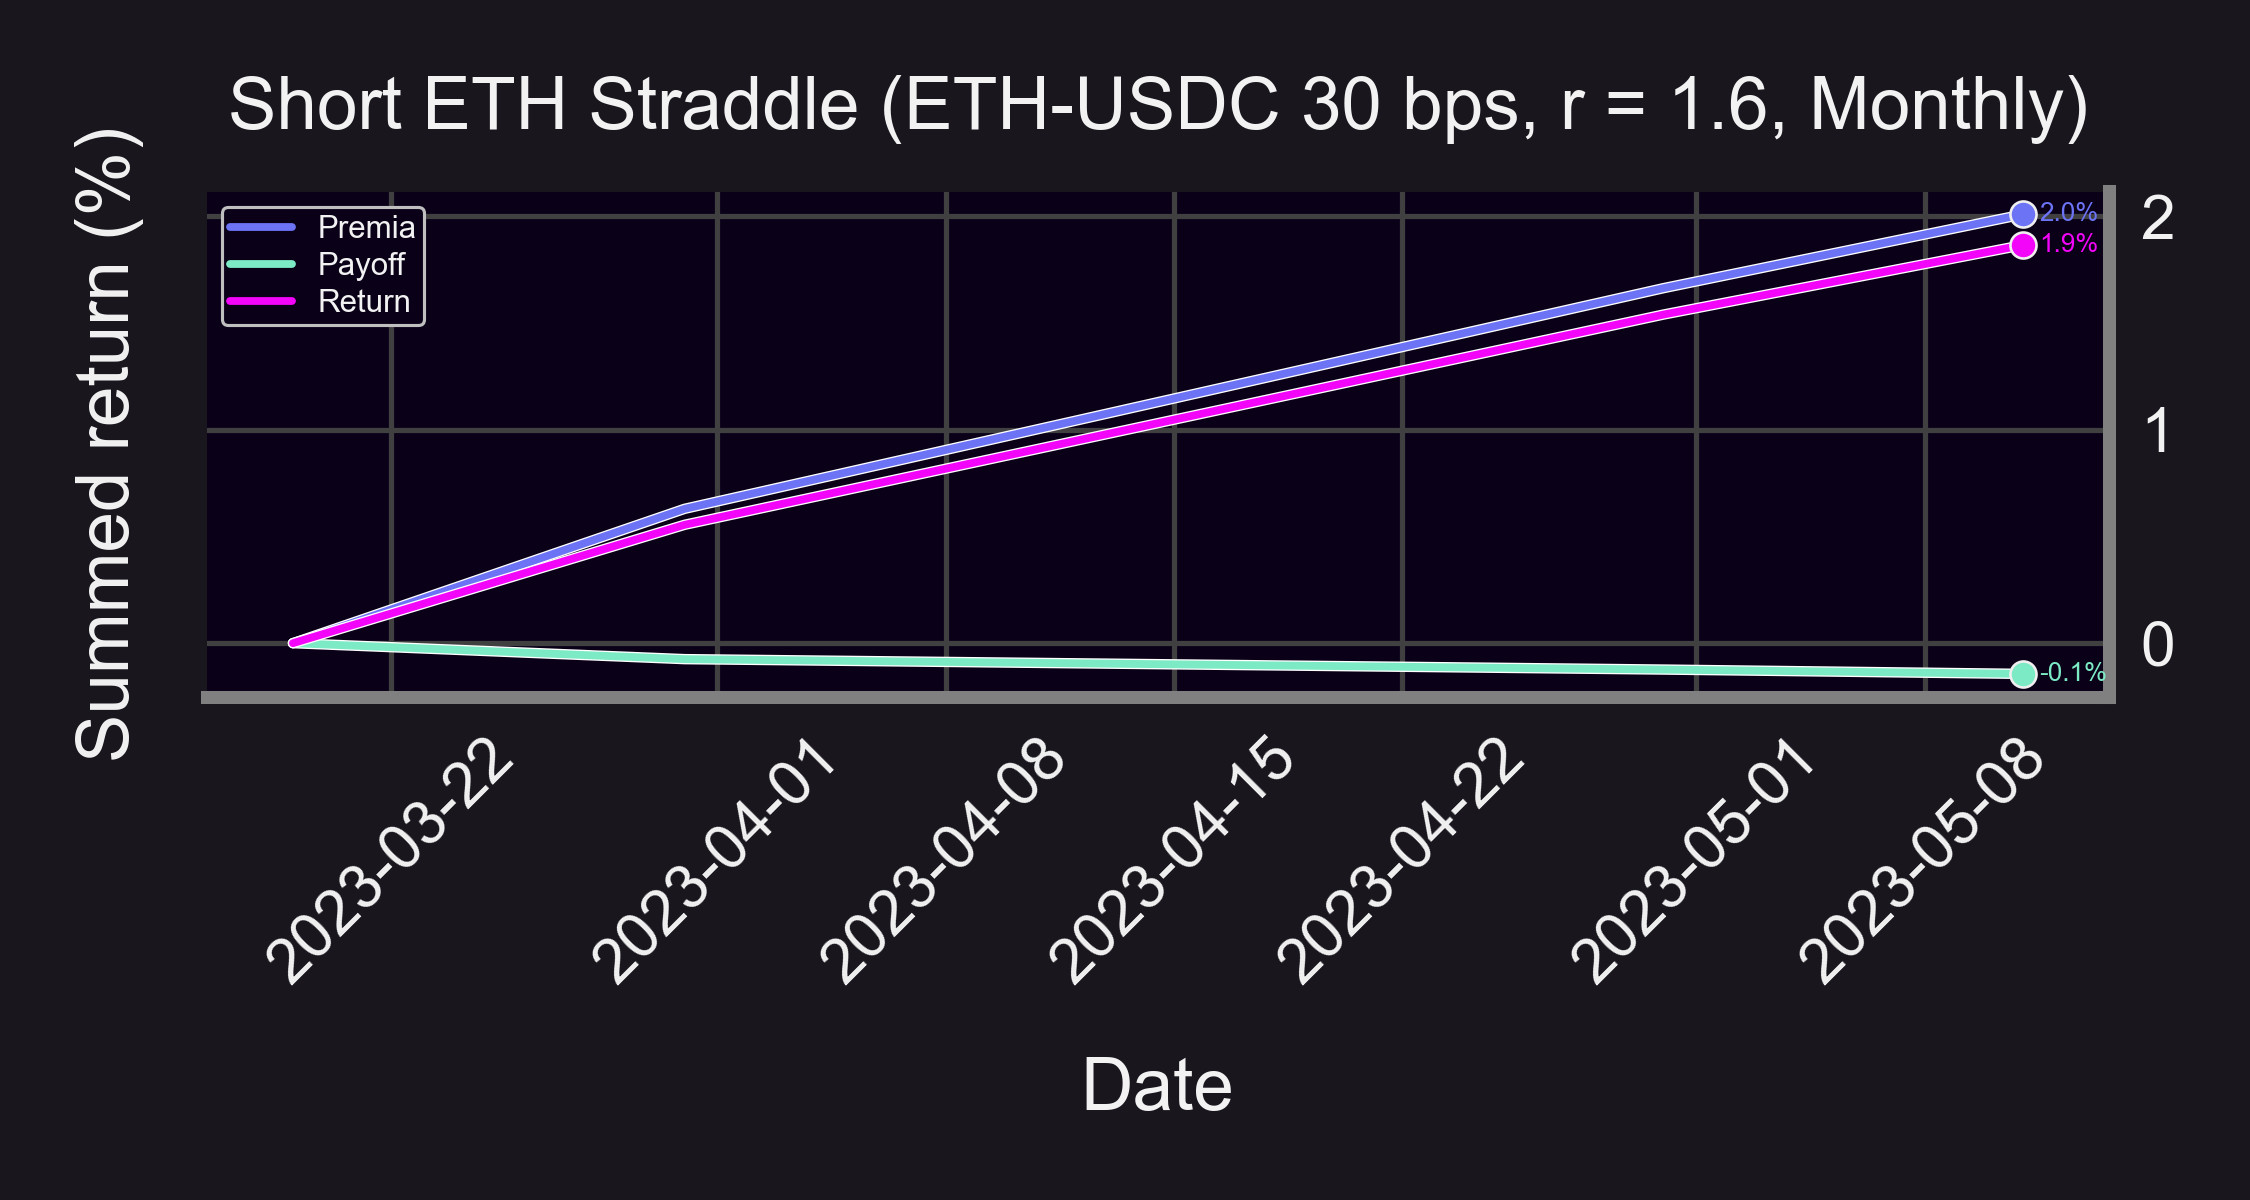

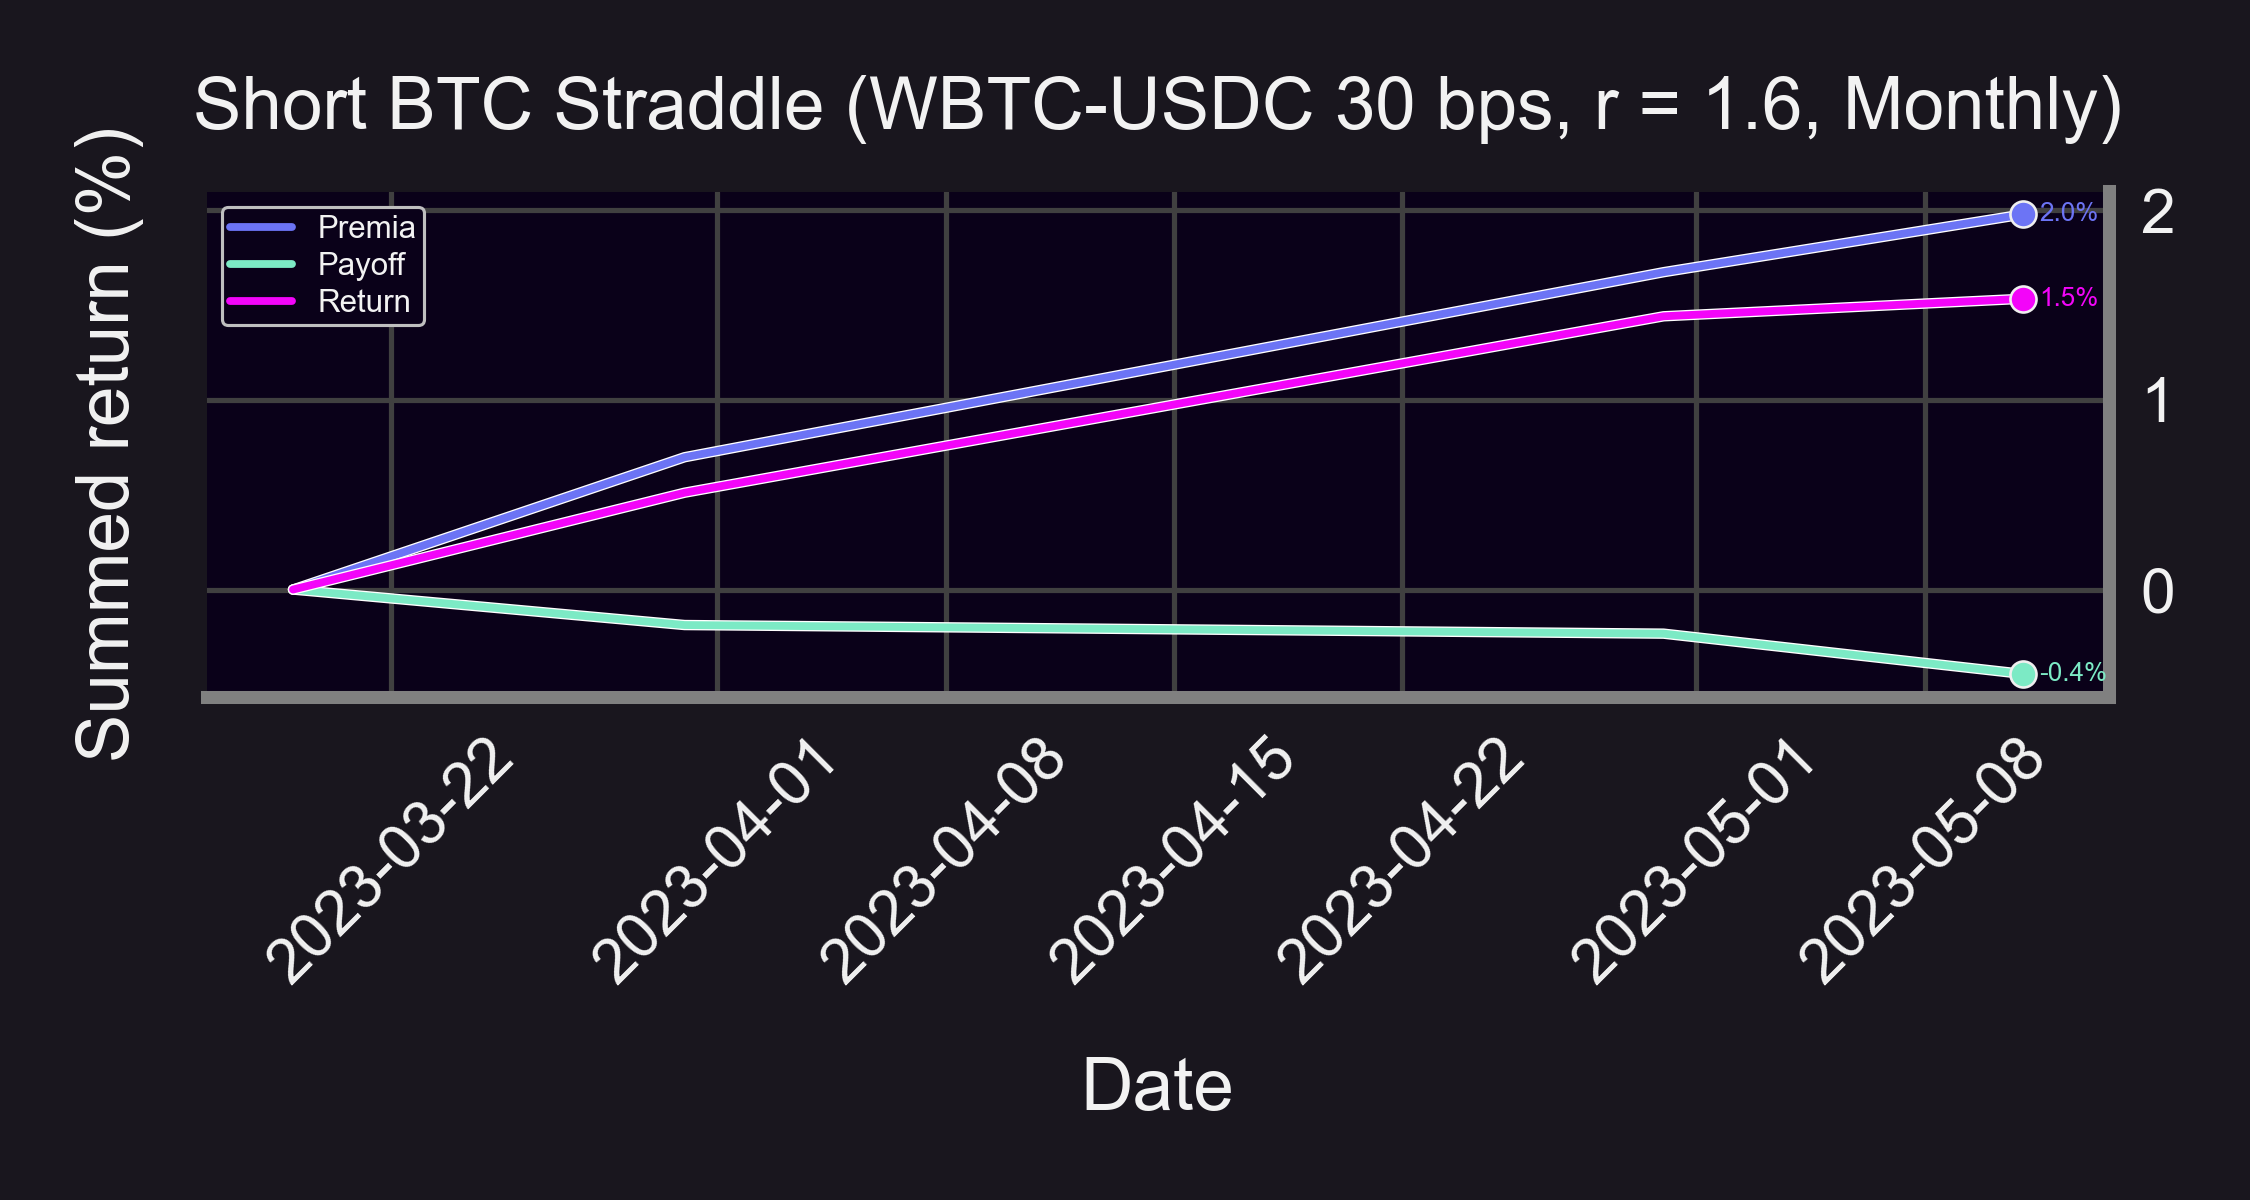

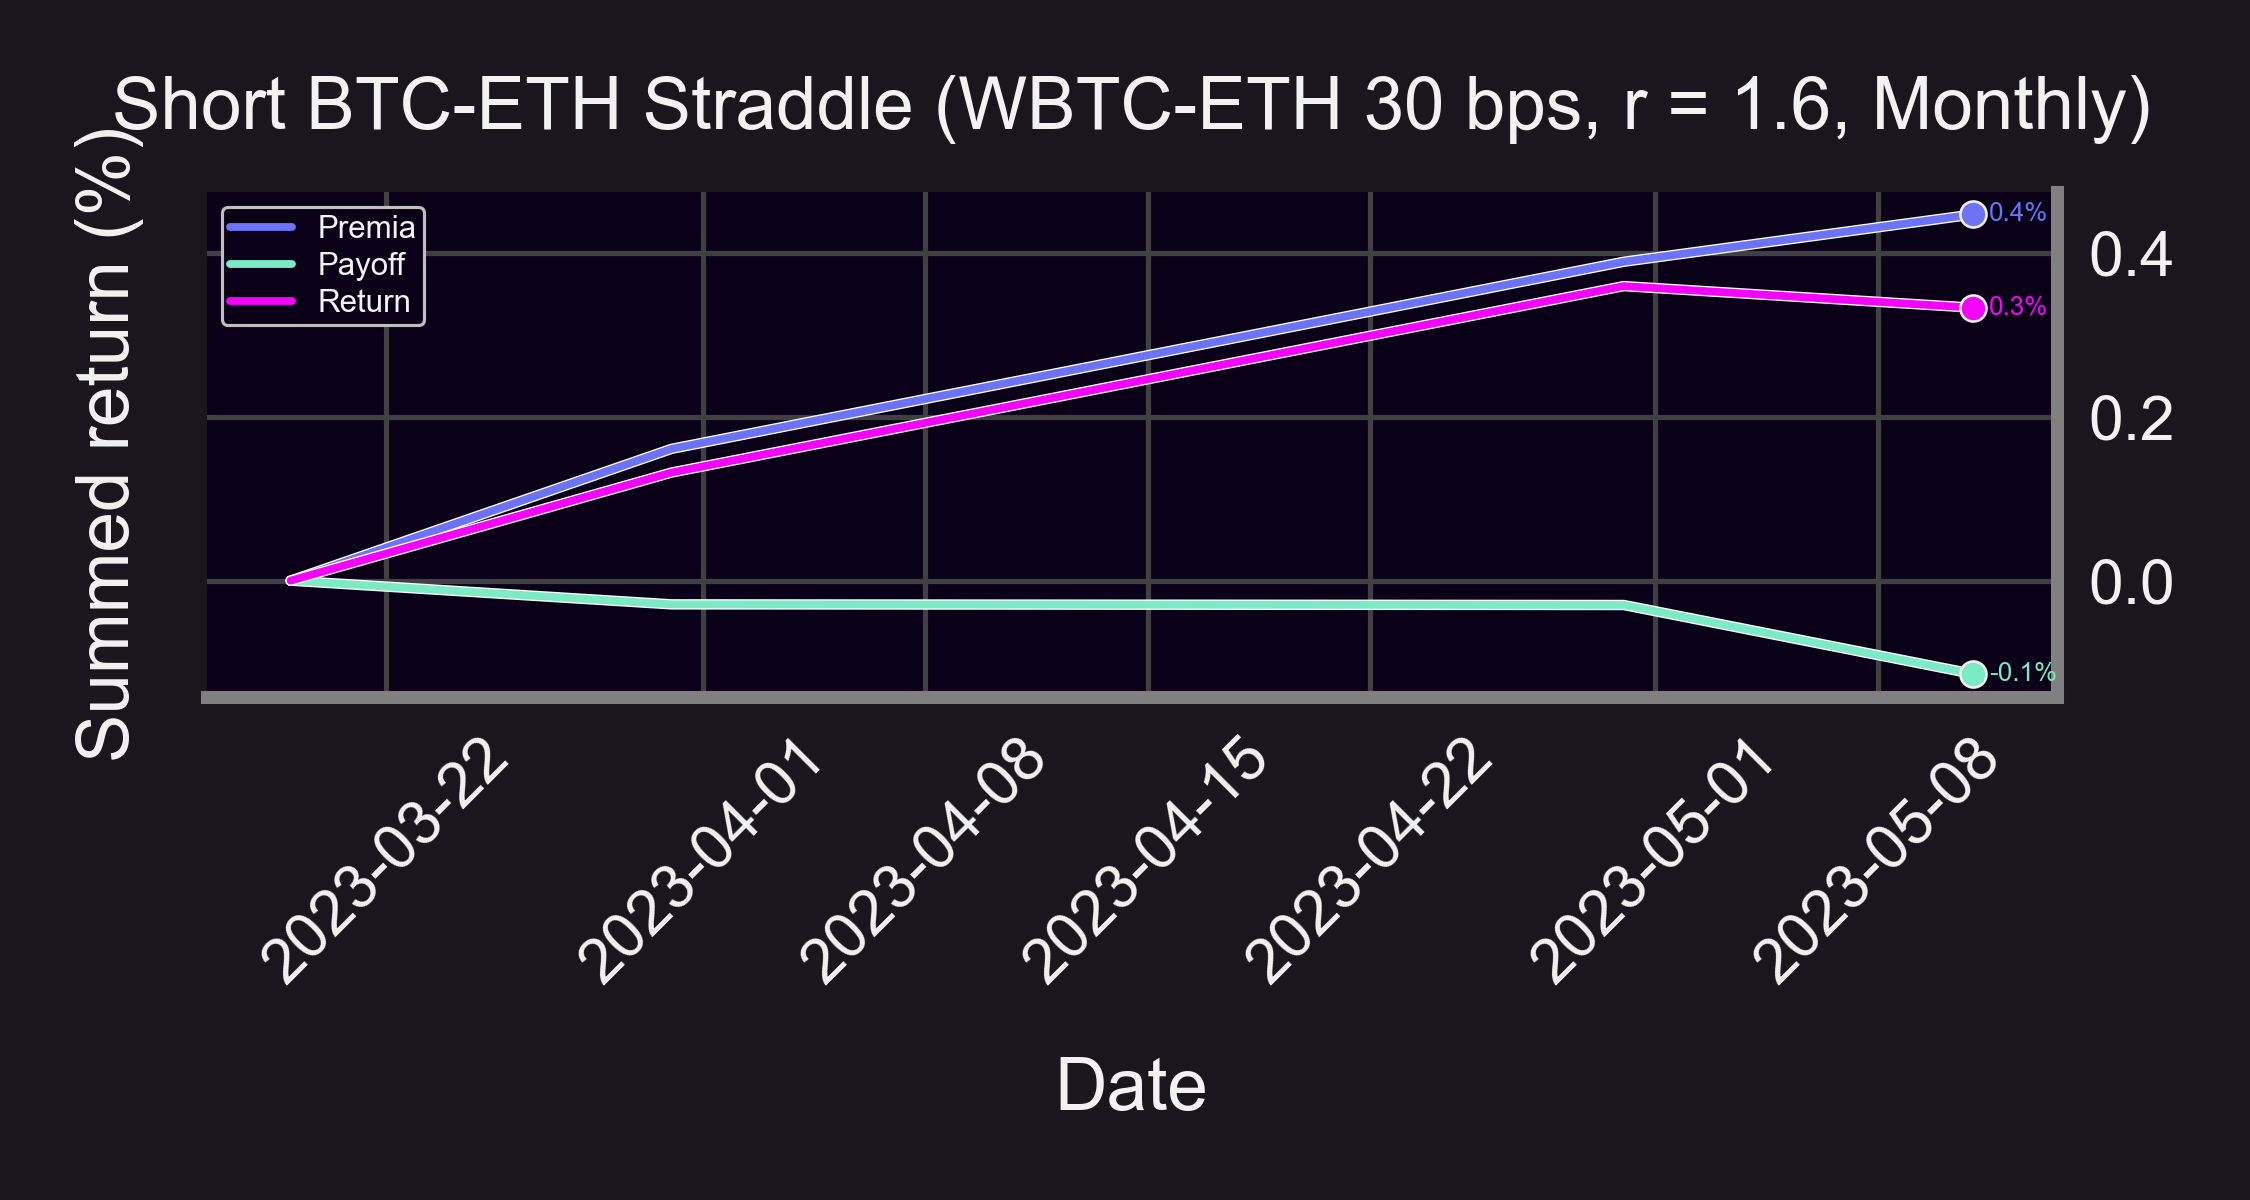

In [230]:
'''Summed Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets['Premia'] = strat.daily_fees['fees_perc']
          rets['Payoff'] = strat.daily_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.daily_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.daily_pos['pnl_perc'] \
                              + strat.daily_fees['fees_perc'] \
                              # - strat.daily_com['coms_perc'] \
                              # + strat.daily_PLP_yield['PLP_yield_perc']
          period_label = 'Daily'
          period_name = 'Dailies'
     if 'a' in period or 'w' in period:
          rets['Premia'] = strat.weekly_fees['fees_perc']
          rets['Payoff'] = strat.weekly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.weekly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.weekly_pos['pnl_perc'] \
                              + strat.weekly_fees['fees_perc'] \
                              # - strat.weekly_com['coms_perc'] \
                              # + strat.weekly_PLP_yield['PLP_yield_perc']
          period_label = 'Weekly'
          period_name = 'Weeklies'
     if 'a' in period or 'm' in period:
          for df in [strat.monthly_fees, strat.monthly_pos]:
               new_date = pd.to_datetime(strat.end_t)
               last_date = df.index[-1]
               new_index = df.index.where(df.index != last_date, new_date)
               df.index = new_index
          rets['Premia'] = strat.monthly_fees['fees_perc']
          rets['Payoff'] = strat.monthly_pos['pnl_perc']
          # rets['Commissions'] = strat.daily_com['coms_perc']
          # rets['PLP_yield'] = strat.monthly_PLP_yield['PLP_yield_perc']
          rets['Return'] = strat.monthly_pos['pnl_perc'] \
                              + strat.monthly_fees['fees_perc'] \
                              # - strat.monthly_com['coms_perc'] \
                              # + strat.monthly_PLP_yield['PLP_yield_perc']
          period_label = 'Monthly'
          period_name = 'Monthlies'

     # Plot rebalancing strategies
     plot_summed_rets(rets = rets,
          xlabel = 'Date',
          ylabel = 'Summed return (%)',
          title = f'Short {strat_label_3(strat)} Straddle ({strat_label_1(strat, period_label)})',
          dir = f"{strat.raw_dir}{strat_label(strat, period_label)}",
          label = True
     )